## DistilBERT

This notebook contains the implementation of the distilBERT pretrained model 

<b>Importing libraries</b>

In [ ]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
from src.main.models.transformers import Transformer
from config import config
from src.main.pipeline.functions import clean_text, stop_words_removal
from src.main.utilities.utils import get_dataset, split_train_val_test
import numpy as np

<b>Model defining and dataset preparation</b>

In [2]:
inputs, targets = get_dataset(one_hot=False)

checkpoint = 'distilbert-base-uncased'

training_args = {
    'output_dir': config.RESULTS_DIRECTORY.format(checkpoint),
    'num_train_epochs': 5,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'logging_dir': config.LOGS_PATH.format(checkpoint),
    'logging_steps': 500,
    'evaluation_strategy': 'epoch',
    'save_strategy': 'epoch',
    'load_best_model_at_end': True,
    'metric_for_best_model': 'accuracy'
}

distilBert = Transformer(checkpoint=checkpoint, **training_args)
distilBert.pipeline = [clean_text, stop_words_removal]
inputs = distilBert.run_pipeline(inputs, save=True)
targets = np.vectorize(config.label2id.get)(targets)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<b>Training and testing the model</b>

Map:   0%|          | 0/75407 [00:00<?, ? examples/s]

Map:   0%|          | 0/21546 [00:00<?, ? examples/s]

Map:   0%|          | 0/10773 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.354000,0.331058,0.891999,0.863781,0.836989,0.848719
2,0.247200,0.343999,0.894876,0.875714,0.831721,0.851173
3,0.186600,0.395525,0.898171,0.871296,0.846595,0.857432
4,0.111700,0.497560,0.895665,0.855930,0.855287,0.855549
5,0.067600,0.551596,0.894876,0.858354,0.848559,0.853295


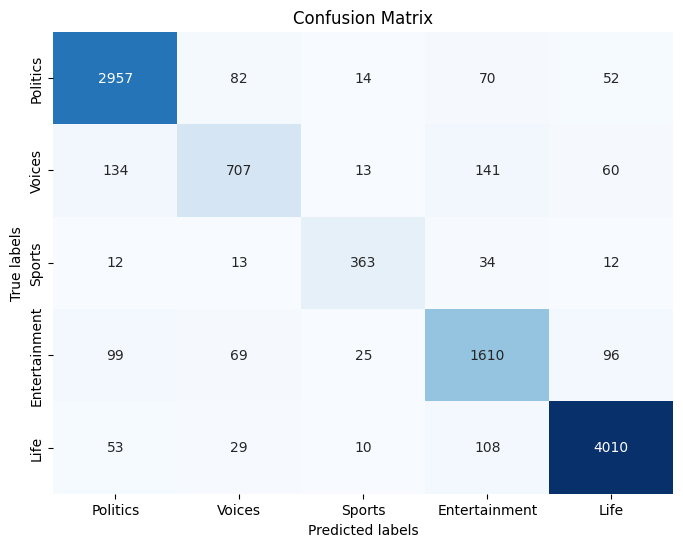

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)

training_dataset, validation_dataset, test_dataset = (
    distilBert.prepare_dataset(x_train, y_train, x_val, y_val, x_test, y_test)
)
distilBert.fit(training_dataset, validation_dataset)

distilBert.save_results(test_dataset)
distilBert.save_model()